In [76]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [77]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta


# Reflect Tables into SQLAlchemy ORM

In [78]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [79]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [80]:
# Declare a Base using `automap_base()`
base = automap_base()

# Use the Base class to reflect the database tables
base.prepare(autoload_with=engine)

In [81]:
# Print all of the classes mapped to the Base
base.classes.keys()

['measurement', 'station']

In [82]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = base.classes.measurement
Station = base.classes.station

In [83]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [84]:
# Find the most recent date in the data set.

# Query the database to get the most recent date
most_recent_date_query = "SELECT MAX(date) FROM Measurement"
most_recent_date_result = engine.execute(most_recent_date_query).scalar()

# Convert the most recent date to a Pandas Timestamp object
most_recent_date = pd.to_datetime(most_recent_date_result)
most_recent_date

Timestamp('2017-08-23 00:00:00')

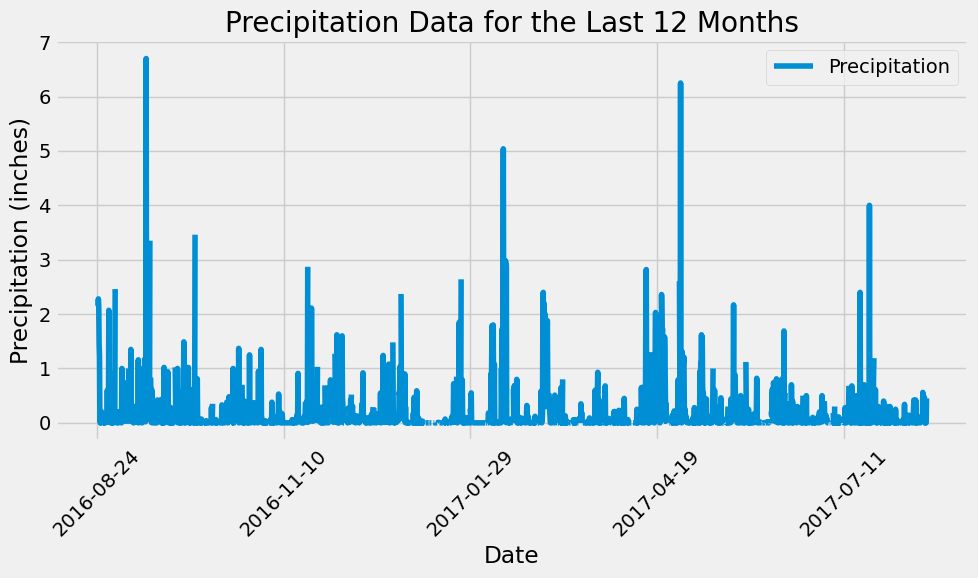

In [85]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the date one year from the last date in data set.
twelve_months_ago = most_recent_date - pd.offsets.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
query = f"SELECT Date, Prcp FROM Measurement WHERE Date >= '{twelve_months_ago}' AND date <= '{most_recent_date}'"
precipitation_data = pd.read_sql_query(query, engine)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(precipitation_data)
prcp_df = prcp_df.rename(columns={'date': 'Date', 'prcp': 'Precipitation'})

# # Sort the dataframe by date
prcp_df.sort_values(by='Date', inplace=True)

# # Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x='Date', y='Precipitation', linestyle='-', figsize=(10, 6))
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [86]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = prcp_df.describe()
summary_statistics

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [87]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station))
total_stations

In [88]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Station.station, func.count(Measurement.id)).\
                        filter(Station.station == Measurement.station).\
                        group_by(Station.station).\
                        order_by(func.count(Measurement.id).desc()).all()

# Print the list of most active stations and their row counts
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [89]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station_id).all()

# Extracting results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Printing the results
print(f"For station {most_active_station_id}:")
print(f"Lowest Temperature: {lowest_temp} F")
print(f"Highest Temperature: {highest_temp} F")
print(f"Average Temperature: {avg_temp} F")

For station USC00519281:
Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66378066378067 F


<Figure size 800x600 with 0 Axes>

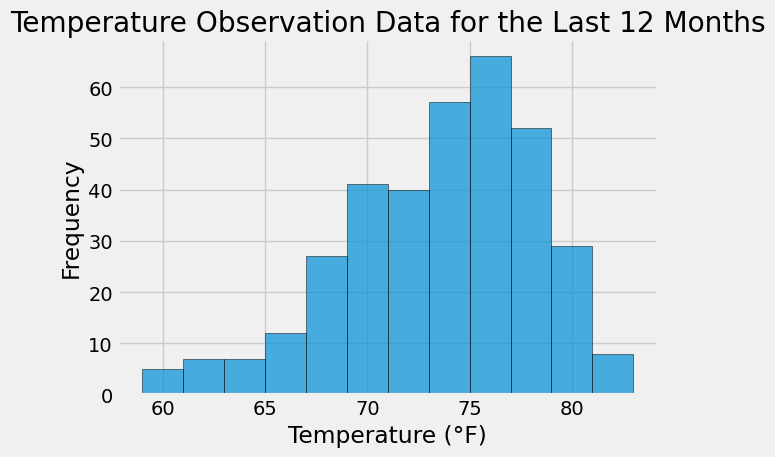

In [90]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the last 12 months of temperature observation data for the most active station
query = f"SELECT Date, Tobs FROM Measurement WHERE date >= '{twelve_months_ago}' AND date <= '{most_recent_date}' AND station = '{most_active_station_id}'"
temperature_data = pd.read_sql_query(query, engine)

# Convert the query result to a DataFrame
temperature_df = pd.DataFrame(temperature_data)
temperature_df = temperature_df.rename(columns={'date': 'Date', 'Tobs': 'Temperature'})

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
temperature_df.hist(bins=12, edgecolor='black', alpha=0.7)
plt.title('Temperature Observation Data for the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [91]:
# Close Session
session.close()
